In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import numpy as np

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
trainDataset = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True
)

valDataset = tf.keras.utils.image_dataset_from_directory(
    'val',
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)

Found 8000 files belonging to 4 classes.


2025-04-25 22:09:38.451858: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-25 22:09:38.451904: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-25 22:09:38.451926: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-25 22:09:38.451952: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-25 22:09:38.452007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 1600 files belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

dataAugmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),

])

def augumentation(x, y):
    x = dataAugmentation(x)
    x = preprocess_input(x)
    return x, y

def normalisation(x, y):
    x = preprocess_input(x)
    return x, y

trainDataset = trainDataset.map(augumentation)
valDataset = valDataset.map(normalisation)


In [ ]:
from tensorflow.keras import regularizers

baseModel = tf.keras.applications.MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

baseModel.trainable = False 

for layer in baseModel.layers[-30:]:
    layer.trainable = True  

mobileNetModel = models.Sequential([
    baseModel,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, use_bias=False, kernel_regularizer=regularizers.L2(1e-5)),
    layers.BatchNormalization(),
    layers.Activation('swish'),
    layers.Dropout(0.5),  
    layers.Dense(4, activation='softmax')
])
metricsList = ['accuracy']
mobileNetModel.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001),loss='categorical_crossentropy',metrics=metricsList)

mobileNetModel.summary()

In [6]:
metricsList = ['accuracy']
mobileNetModel.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001),loss='categorical_crossentropy',metrics=metricsList)

mobileNetModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       122,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,120,260 (11.90 MB)

 Trainable params: 1,718,372 (6.56 MB)

 Non-trainable params: 1,401,888 (5.35 MB)

In [ ]:
callBacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("MobileNet.keras", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-5
    )

]

MobileNetHistory = mobileNetModel.fit(
    trainDataset,
    validation_data=valDataset,
    epochs=50,
    callbacks=callBacks,
)

Epoch 1/50


2025-04-25 22:17:13.370952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


250/250 ━━━━━━━━━━━━━━━━━━━━ 124s 447ms/step - accuracy: 0.4500 - loss: 1.3306 - val_accuracy: 0.4475 - val_loss: 1.6090 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 437ms/step - accuracy: 0.7614 - loss: 0.6527 - val_accuracy: 0.5800 - val_loss: 1.2252 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 155s 620ms/step - accuracy: 0.8116 - loss: 0.5341 - val_accuracy: 0.6900 - val_loss: 0.8963 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 556ms/step - accuracy: 0.8298 - loss: 0.4674 - val_accuracy: 0.7862 - val_loss: 0.6330 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 122s 487ms/step - accuracy: 0.8487 - loss: 0.4256 - val_accuracy: 0.7931 - val_loss: 0.5962 - learning_rate: 1.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 121s 482ms/step - accuracy: 0.8483 - loss: 0.4146 - val_accuracy: 0.8369 - val_loss: 0.4671 - learning_rate: 1.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 125s 498ms/

In [ ]:
import pickle

with open('MobileNet.pkl', 'wb') as f:
    pickle.dump(MobileNetHistory.history, f)

In [ ]:
import pickle
with open('MobileNet.pkl', 'rb') as f:
    loadedHistory = pickle.load(f)
loadedHistory

{'accuracy': [0.578499972820282,
  0.778124988079071,
  0.8203750252723694,
  0.8327500224113464,
  0.8496249914169312,
  0.8550000190734863,
  0.8662499785423279,
  0.8693749904632568,
  0.874750018119812,
  0.8862500190734863,
  0.8886250257492065,
  0.8930000066757202,
  0.8987500071525574,
  0.9056249856948853,
  0.9001250267028809,
  0.9052500128746033,
  0.9087499976158142,
  0.9091249704360962,
  0.9146249890327454,
  0.9152500033378601,
  0.9122499823570251,
  0.9196249842643738,
  0.9185000061988831,
  0.9141250252723694,
  0.9173750281333923,
  0.9152500033378601,
  0.9166250228881836,
  0.9178749918937683,
  0.9166250228881836,
  0.9196249842643738,
  0.9282500147819519,
  0.9198750257492065,
  0.9223750233650208,
  0.9290000200271606,
  0.9235000014305115,
  0.9194999933242798,
  0.9241250157356262,
  0.9207500219345093,
  0.9271249771118164],
 'loss': [1.0389108657836914,
  0.6006374955177307,
  0.5037678480148315,
  0.4552898705005646,
  0.41666239500045776,
  0.397808253

In [ ]:
testDataset = tf.keras.utils.image_dataset_from_directory(
    'test',
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)

class_names = testDataset.class_names

Found 968 files belonging to 4 classes.
['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [ ]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

def normalisation(x, y):
    x = preprocess_input(x)
    return x, y

testDataset = testDataset.map(normalisation)

In [ ]:
loss, accuracy = mobileNetModel.evaluate(testDataset)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.9835 - loss: 0.0559
Test Loss: 0.0567
Test Accuracy: 98.86%


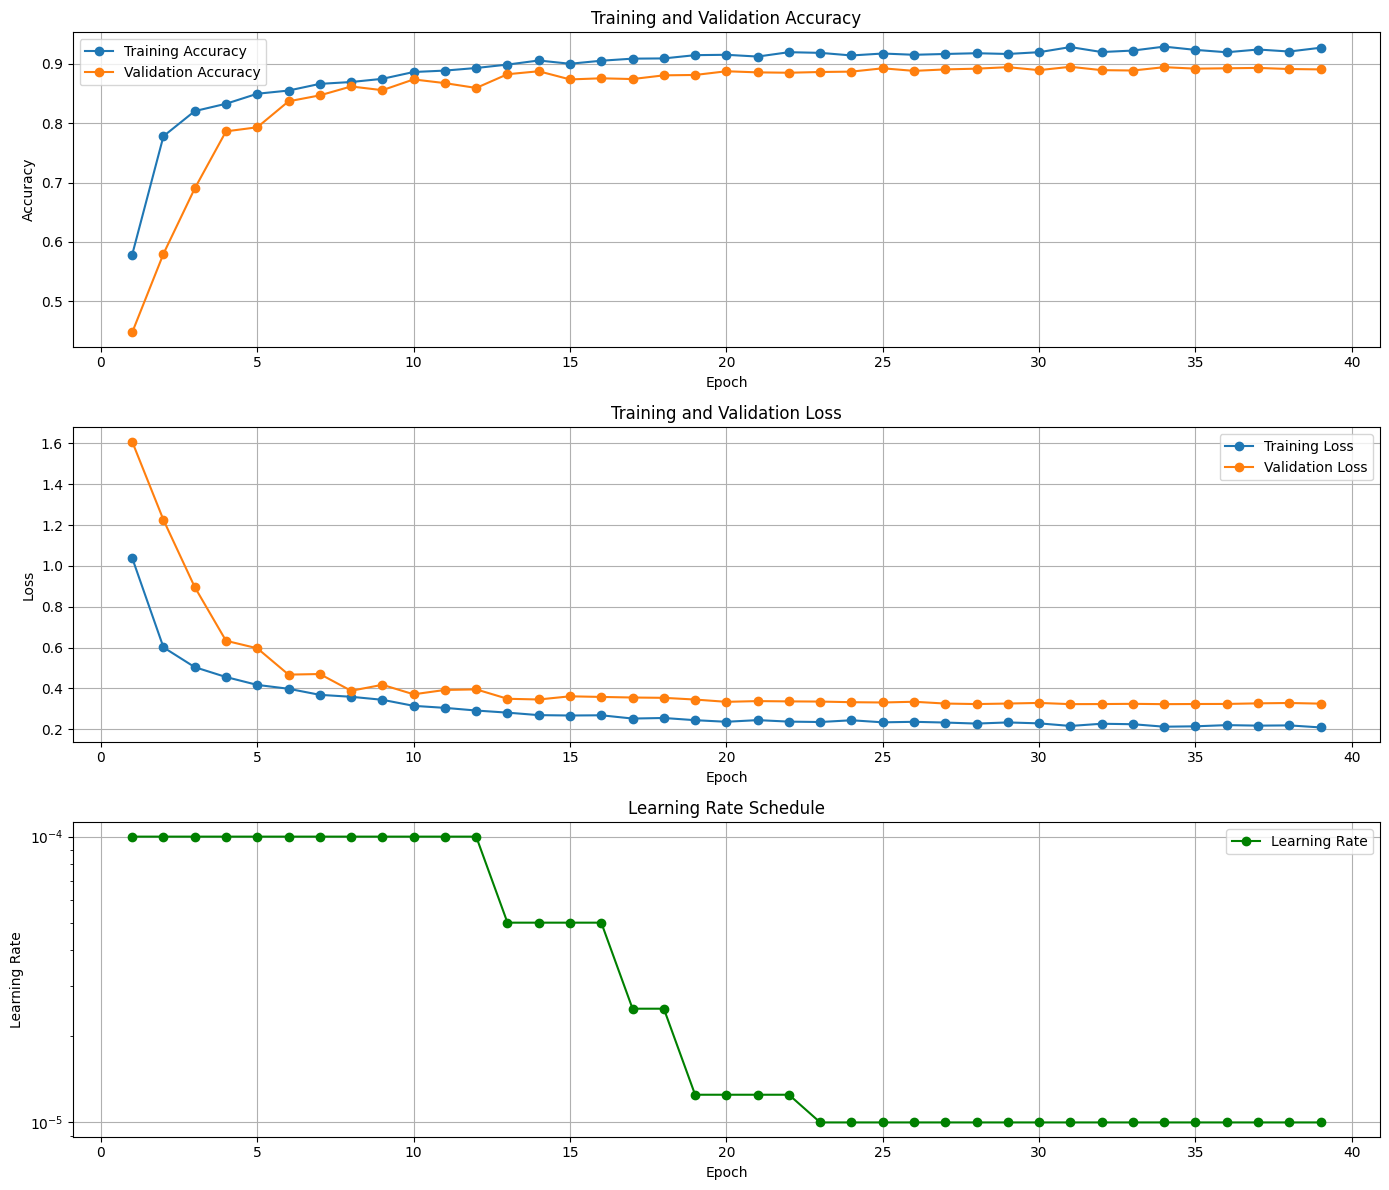

In [ ]:
import matplotlib.pyplot as plt

acc = loadedHistory['accuracy']
val_acc = loadedHistory['val_accuracy']
loss = loadedHistory['loss']
val_loss = loadedHistory['val_loss']
lr = loadedHistory['learning_rate'] 
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 12)) 

plt.subplot(3, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(epochs_range, lr, label='Learning Rate', marker='o', color='green')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

y_true = []
y_pred_probs = []

for images, labels in testDataset:
    preds = mobileNetModel.predict(images)
    y_pred_probs.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

class_names = class_names

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

2025-04-26 10:56:58.656567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

         CNV       0.98      0.98      0.98       242
         DME       1.00      0.99      0.99       242
      DRUSEN       0.98      0.98      0.98       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



In [26]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro')
f1_weighted = f1_score(y_true_labels, y_pred_labels, average='weighted')
precision = precision_score(y_true_labels, y_pred_labels, average='macro')
recall = recall_score(y_true_labels, y_pred_labels, average='macro')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")


F1 Score (Macro): 0.9886
F1 Score (Weighted): 0.9886
Precision (Macro): 0.9887
Recall (Macro): 0.9886


AUC for class 'CNV': 0.9994
AUC for class 'DME': 0.9992
AUC for class 'DRUSEN': 0.9988
AUC for class 'NORMAL': 0.9997


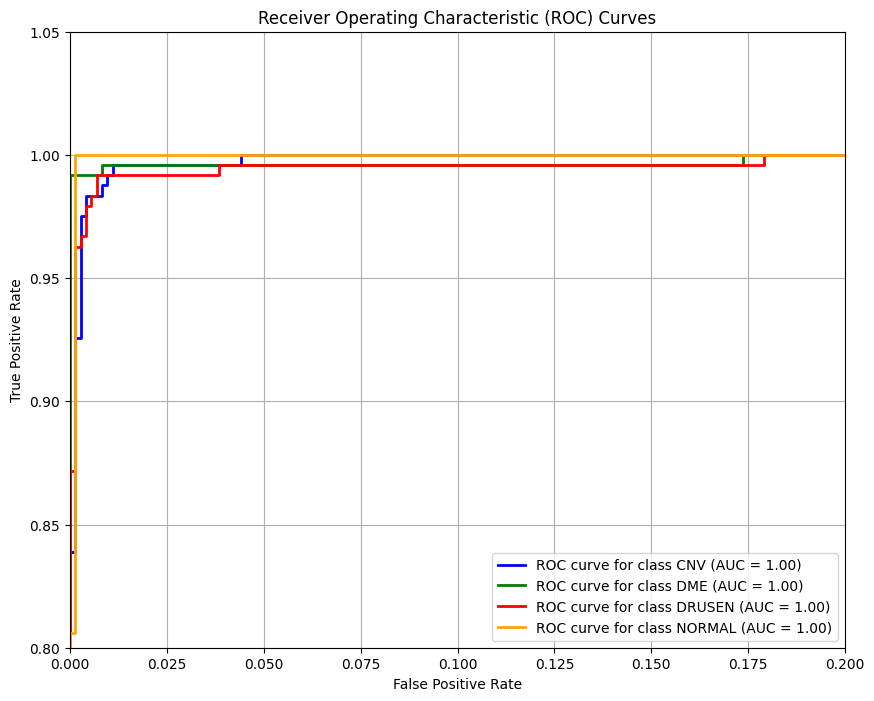

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle

n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"AUC for class '{class_names[i]}': {roc_auc[i]:.4f}")

colors = cycle(['blue', 'green', 'red', 'orange', 'purple', 'brown'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve for class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Confusion Matrix in Array Format:
[[238   0   4   0]
 [  1 240   0   1]
 [  3   1 238   0]
 [  0   0   1 241]]


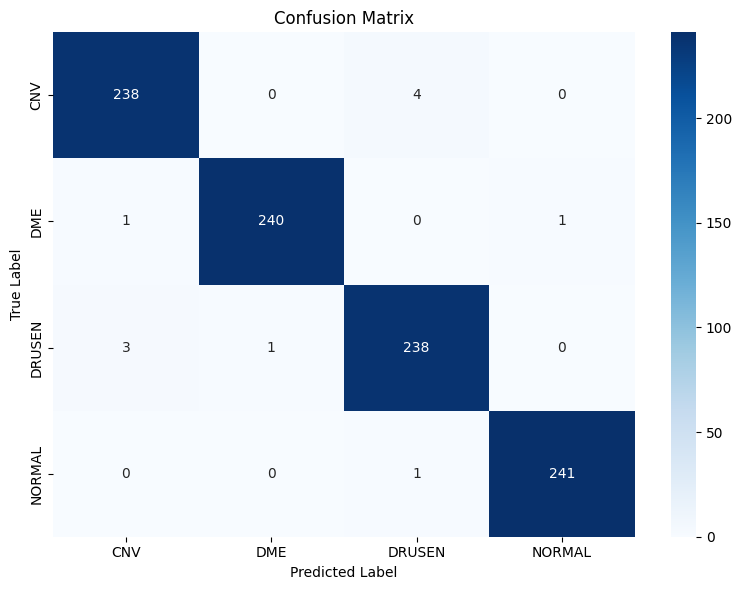

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

print("Confusion Matrix in Array Format:")
print(conf_mat)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()